In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import linear_model, decomposition, datasets
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [3]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
2317150,MAGISTRATES,LA TROBE STREET,SPENCER STREET,KING STREET,4,3969S,03/12/2011 05:35:41 PM,03/12/2011 05:38:19 PM,158,2P TKT A M-SAT 7:30-20:30,0,856,2192
4633962,VICTORIA MARKET,QUEEN STREET,VICTORIA STREET,THERRY STREET,2,4990E,12/02/2012 05:41:14 PM,12/02/2012 06:30:00 PM,2926,S/ NO STOP SUN 6:00-18:30,1,1171,3050
11546157,CHINATOWN,RUSSELL STREET,LONSDALE STREET,LT BOURKE STREET,5,793W,10/09/2012 05:35:46 PM,10/09/2012 05:52:32 PM,1006,1/2P MTR M-SAT 7:30-19:30,0,1221,492
10320428,HYATT,EXHIBITION STREET,LT COLLINS STREET,COLLINS STREET,2,362E,03/08/2012 10:13:27 PM,03/08/2012 10:47:22 PM,2035,4P DIS ONLY M-SUN,0,647,7096
3885230,SPENCER,FRANCIS STREET,SPENCER STREET,KING STREET,3,2118N,20/01/2012 03:59:56 PM,20/01/2012 04:00:00 PM,4,1P MTR M-F 9:30-16:00,0,679,1704


In [4]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [5]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [6]:
#Target field identification
target = parkingdata['In Violation?']

In [7]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('In Violation?', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['Side Of Street'] = parkingdata['Side Of Street']
features['Duration of Parking Event (in seconds)'] = parkingdata['Duration of Parking Event (in seconds)']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,Side Of Street,Duration of Parking Event (in seconds),Street ID,Device ID,Arrival Hour,Departure Hour
2317150,0,0,0,0,0,4,158,856,2192,17,17
4633962,1,1,1,1,1,2,2926,1171,3050,17,18
11546157,2,2,2,2,2,5,1006,1221,492,17,17
10320428,3,3,3,3,3,2,2035,647,7096,22,22
3885230,4,4,0,0,4,3,4,679,1704,15,16
9335987,2,2,4,4,5,1,421,1221,446,15,15
9066009,5,5,5,5,6,5,689,706,6566,18,18
10212553,6,6,6,6,7,4,726,894,6954,10,10
11328556,5,7,5,7,8,2,7413,1054,6657,10,12
5634431,7,2,7,8,2,5,461,1221,524,14,14


In [8]:
#Parameter Tuning
         ####NOTE: random_split=1 for test_train
#Define the parameters to tune and the values to tune to
params_dtc = [
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [None,1, 2, 4, 10],
        'max_depth': [None, 4, 10, 15],
        'splitter' : ['best', 'random'],
        'min_samples_split':[None,5, 8, 10, 12, 14, 16]
    }
]

In [9]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_dtc = GridSearchCV(estimator = DecisionTreeClassifier(),
                      param_grid = params_dtc, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [10]:
#Fit the model with the dataset
bestModel = gs_dtc.fit(features, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   45.2s finished


In [11]:
#Find the best values for the  parameters of the model (Standard output)
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'splitter': 'best'}

In [12]:
#Find the best values for the  parameters of the model (Formatted output)
best_criterion = bestModel.best_estimator_.get_params()['criterion']
best_max_depth =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion)
print('Best max_depth: ', best_max_depth )
print('Best min_samples_leaf: ', best_min_samples_leaf )
print('Best min_samples_split: ', best_min_samples_split)
print('Best splitter: ', best_splitter)

Best criterion:  entropy
Best max_depth:  None
Best min_samples_leaf:  2
Best min_samples_split:  5
Best splitter:  best


In [13]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9209
556,entropy,15.0,10.0,14.0,best,0.9639
557,entropy,15.0,10.0,14.0,random,0.9250
558,entropy,15.0,10.0,16.0,best,0.9633


In [14]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
dtc = metric = DecisionTreeClassifier(criterion = best_criterion, 
                               max_depth = best_max_depth, 
                               min_samples_leaf = best_min_samples_leaf,
                               min_samples_split = best_min_samples_split,
                               splitter = best_splitter,
                               random_state = 0
                               )

In [15]:
# Hill climbing
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.8715
Score with 2 selected features: 0.8795
Score with 3 selected features: 0.9805
Score with 4 selected features: 0.983

Indexs of the desired features
[2, 4, 6, 5]


In [16]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Sign,Duration of Parking Event (in seconds),Side Of Street
2317150,0,0,158,4
4633962,1,1,2926,2
11546157,2,2,1006,5
10320428,3,3,2035,2
3885230,0,4,4,3
9335987,4,5,421,1
9066009,5,6,689,5
10212553,6,7,726,4
11328556,5,8,7413,2
5634431,7,2,461,5


In [17]:
bestModel = gs_dtc.fit(features_hc, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1408 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   26.2s finished


In [18]:
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'splitter': 'best'}

In [19]:
best_criterion_hc = bestModel.best_estimator_.get_params()['criterion']
best_max_depth_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf_hc =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split_hc =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter_hc =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion_hc)
print('Best max_depth: ', best_max_depth_hc )
print('Best min_samples_leaf: ', best_min_samples_leaf_hc )
print('Best min_samples_split: ', best_min_samples_split_hc)
print('Best splitter: ', best_splitter_hc)

Best criterion:  gini
Best max_depth:  None
Best min_samples_leaf:  1
Best min_samples_split:  5
Best splitter:  best


In [20]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.9196
556,entropy,15.0,10.0,14.0,best,0.9650
557,entropy,15.0,10.0,14.0,random,0.9287
558,entropy,15.0,10.0,16.0,best,0.9651


In [21]:
dtc = metric = DecisionTreeClassifier(criterion = best_criterion_hc, 
                               max_depth = best_max_depth_hc, 
                               min_samples_leaf = best_min_samples_leaf_hc,
                               min_samples_split = best_min_samples_split_hc,
                               splitter = best_splitter_hc,
                               random_state = 0
                               )

In [22]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = confusion_matrix(y_test,predicted)
print("Confusion Matrix")
print(cm)

#Printing the numerical result of the confusion matrix
print("\n[Train/test split] score: {:.5f}".format(dtc.score(x_test, y_test)))

print(classification_report(y_test, predicted))

Confusion Matrix
[[4283   72]
 [ 119  526]]

[Train/test split] score: 0.96180
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4355
           1       0.88      0.82      0.85       645

    accuracy                           0.96      5000
   macro avg       0.93      0.90      0.91      5000
weighted avg       0.96      0.96      0.96      5000



In [23]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nDecision Tree mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.97100
[fold 1] score: 0.97900
[fold 2] score: 0.96950
[fold 3] score: 0.96850
[fold 4] score: 0.97500

Decision Tree mean score [5 folds] = 0.9726


In [24]:
#visualise the tree
from sklearn import tree
with open('violationTarget1.dot', 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f, feature_names=None, class_names=None, filled=True, rounded=True, special_characters=True)
    



 Accuracy score: 0.96180

 Misclassification Rate: 0.03820

 True Positive Rate: 0.81550

 True Negative Rate: 0.98347

 Precision : 0.87960

 Prevalence : 0.12900

 F score : 0.84634

 False Positive Rate: 0.01653


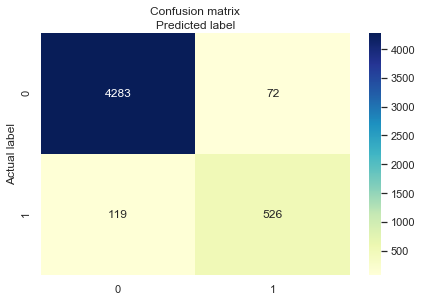

In [25]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(dtc.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

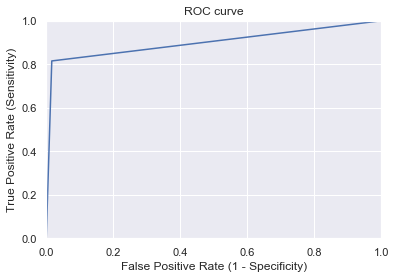

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predicted)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [27]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.97100
[fold 1] score: 0.97900
[fold 2] score: 0.96950
[fold 3] score: 0.96850
[fold 4] score: 0.97500

KNN mean score [5 folds] = 0.9726
